In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

print("All preprocessing libraries imported.")

All preprocessing libraries imported.


In [3]:
# Load the data we cleaned during EDA
train_df = pd.read_csv('train_cleaned.csv')
test_df = pd.read_csv('test_cleaned.csv')

print("Cleaned training data loaded.")
print(train_df.head())

Cleaned training data loaded.
    Loan_ID Gender Married  Dependents     Education Self_Employed  \
0  LP001002   Male      No           0      Graduate            No   
1  LP001003   Male     Yes           1      Graduate            No   
2  LP001005   Male     Yes           0      Graduate           Yes   
3  LP001006   Male     Yes           0  Not Graduate            No   
4  LP001008   Male      No           0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0       128.0             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rura

Feature Engineering

    EDA Insight: We suspected ApplicantIncome and CoapplicantIncome might be more useful together. Your note on improving models also lists "Feature Creation" as a key technique.

    Action: Let's create Total_Income and Debt to Income Ratio from our new log-transformed features.

In [4]:
# We do this for both train and test data
for df in [train_df, test_df]:
    # 1. Create Total_Income
    df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

    # 2. Create Debt_to_Income_Ratio
    # We'll use .replace to handle potential division by zero if Total_Income is 0
    df['Debt_to_Income_Ratio'] = df['LoanAmount'] / (df['Total_Income'].replace(0, 1))

print("New features 'Total_Income' and 'Debt_to_Income_Ratio' created.")

New features 'Total_Income' and 'Debt_to_Income_Ratio' created.


Handle Skewness (Log Transformation)

    EDA Insight: ApplicantIncome, CoapplicantIncome, LoanAmount, and our new features (Total_Income, Debt_to_Income_Ratio) are all skewed.

    Action: Apply the log transform to all of them. We'll use np.log1p() which is log(x + 1), to handle any zero values gracefully.

In [5]:
# Define all columns that need to be log-transformed
skewed_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
               'Total_Income', 'Debt_to_Income_Ratio']

for df in [train_df, test_df]:
    for col in skewed_cols:
        # Create new log-transformed columns
        df[col + '_Log'] = np.log1p(df[col])

print("Log transformation applied to all skewed numerical features.")

Log transformation applied to all skewed numerical features.


Separate Features (X) and Target (y)

    Action: Now we define our X and y. We will drop all the original (non-log) numerical columns and keep only the new _Log versions.

In [6]:
# Define the target variable (y)
target = 'Loan_Status'
train_df[target] = train_df[target].map({'Y': 1, 'N': 0})
y = train_df[target]


# Define features to drop from the TRAINING data (X)
features_to_drop_X = [
    'Loan_ID', 'Loan_Status',  # <-- Loan_Status is here
    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
    'Total_Income', 'Debt_to_Income_Ratio'
]
X = train_df.drop(columns=features_to_drop_X)

# Define features to drop from the TEST data (X_test_final)
# It's the same list, but WITHOUT 'Loan_Status'
features_to_drop_X_test = [
    'Loan_ID',  # <-- No 'Loan_Status'
    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
    'Total_Income', 'Debt_to_Income_Ratio'
]
X_test_final = test_df.drop(columns=features_to_drop_X_test)

print(f"Features for modeling (X): \n{X.columns.tolist()}")
print(f"\nFeatures for final test set (X_test_final): \n{X_test_final.columns.tolist()}")

Features for modeling (X): 
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'ApplicantIncome_Log', 'CoapplicantIncome_Log', 'LoanAmount_Log', 'Total_Income_Log', 'Debt_to_Income_Ratio_Log']

Features for final test set (X_test_final): 
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'ApplicantIncome_Log', 'CoapplicantIncome_Log', 'LoanAmount_Log', 'Total_Income_Log', 'Debt_to_Income_Ratio_Log']


Define Columns for Preprocessing Pipeline

    Action: We list our final numerical and categorical features for the pipeline.

In [7]:
# All our final numerical features end in '_Log'
numerical_features = [
    'ApplicantIncome_Log', 'CoapplicantIncome_Log', 'LoanAmount_Log',
    'Total_Income_Log', 'Debt_to_Income_Ratio_Log', 'Loan_Amount_Term'
]

categorical_features = [
    'Gender', 'Married', 'Dependents',
    'Education', 'Self_Employed',
    'Credit_History', 'Property_Area'
]

print(f"Final Numerical features for pipeline: \n {numerical_features}")
print(f"Final Categorical features for pipeline: \n {categorical_features}")

Final Numerical features for pipeline: 
 ['ApplicantIncome_Log', 'CoapplicantIncome_Log', 'LoanAmount_Log', 'Total_Income_Log', 'Debt_to_Income_Ratio_Log', 'Loan_Amount_Term']
Final Categorical features for pipeline: 
 ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']


Split the Data (Train-Test Split)

    Action: Split our data for training and validation, as discussed in the notes.

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Essential for our imbalanced 'Loan_Status' target
)

print(f"Data split into: \n  X_train: {X_train.shape} \n  X_val: {X_val.shape}")

Data split into: 
  X_train: (491, 13) 
  X_val: (123, 13)


Create and Apply the Preprocessing Pipeline

    Action: Same as before, but using our updated and corrected column lists. We'll use StandardScaler for numerical and OneHotEncoder for categorical features

In [9]:
# Create the numerical transformer (Scaling)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create the categorical transformer (Encoding)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create the master ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Fit the preprocessor on X_train and transform both X_train and X_val
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print("Preprocessing pipeline created and applied.")
print(f"New X_train_processed shape: {X_train_processed.shape}")

Preprocessing pipeline created and applied.
New X_train_processed shape: (491, 23)


# This is just checking to see if handling skewness is effective

--- Displaying Log-Transformed ('Normalized') Features ---


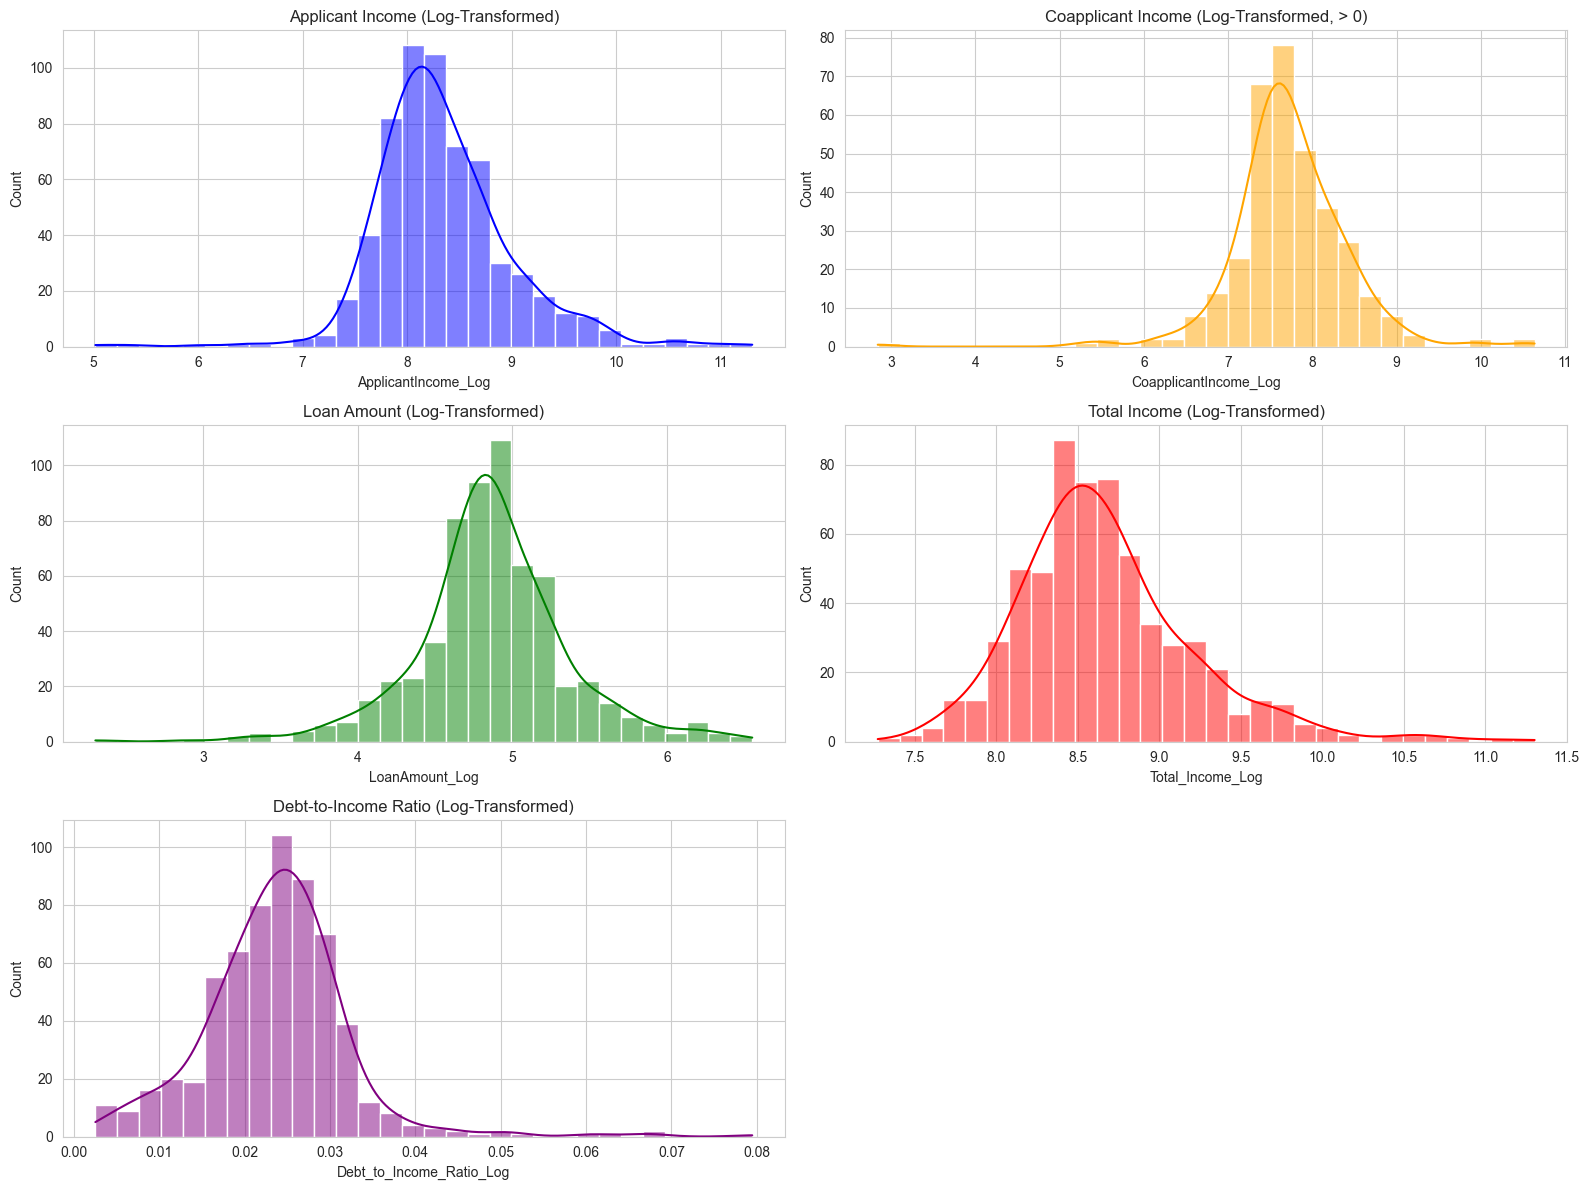

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# (This assumes 'train_df' is in memory from the previous step,
#  where we created the new '_Log' columns)

print("--- Displaying Log-Transformed ('Normalized') Features ---")

plt.figure(figsize=(16, 12))
sns.set_style("whitegrid")

# Plot 1: ApplicantIncome_Log
plt.subplot(3, 2, 1)
sns.histplot(train_df['ApplicantIncome_Log'], kde=True, bins=30, color='blue')
plt.title('Applicant Income (Log-Transformed)')

# Plot 2: CoapplicantIncome_Log
plt.subplot(3, 2, 2)
# We filter out the -inf values from log(0+1) which is 0
sns.histplot(train_df['CoapplicantIncome_Log'][train_df['CoapplicantIncome_Log'] > 0], kde=True, bins=30, color='orange')
plt.title('Coapplicant Income (Log-Transformed, > 0)')

# Plot 3: LoanAmount_Log
plt.subplot(3, 2, 3)
sns.histplot(train_df['LoanAmount_Log'], kde=True, bins=30, color='green')
plt.title('Loan Amount (Log-Transformed)')

# Plot 4: Total_Income_Log
plt.subplot(3, 2, 4)
sns.histplot(train_df['Total_Income_Log'], kde=True, bins=30, color='red')
plt.title('Total Income (Log-Transformed)')

# Plot 5: Debt_to_Income_Ratio_Log
plt.subplot(3, 2, 5)
sns.histplot(train_df['Debt_to_Income_Ratio_Log'], kde=True, bins=30, color='purple')
plt.title('Debt-to-Income Ratio (Log-Transformed)')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Create an instance of the model
# We set class_weight='balanced' to help with our imbalanced data
model = LogisticRegression(random_state=42, class_weight='balanced')

# 2. Train the model on the processed training data
model.fit(X_train_processed, y_train)

# 3. Make predictions on the training data (just to see how it did)
train_preds = model.predict(X_train_processed)
train_accuracy = accuracy_score(y_train, train_preds)

# 4. Make predictions on the VALIDATION data (the "final exam")
val_preds = model.predict(X_val_processed)
val_accuracy = accuracy_score(y_val, val_preds)

print(f"--- Logistic Regression Baseline ---")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

--- Logistic Regression Baseline ---
Training Accuracy: 76.37%
Validation Accuracy: 84.55%
